## This notebook is intended to prepare extracted buoy data from the [CDIP website](https://cdip.ucsd.edu/) for a rogue wave forecasting task for buoys in a localized triangular area.

### The required libraries are imported here.

In [2]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from tensorflow import keras
import seaborn as sns
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix

- **A function to extract the wave heights and their respective indices in a given time series window. This is based on finding the zero-crossing incidents in the time window. Finally, the largest of the wave peaks in the window is found out.**
- **This is done to process the data in a manner such that the wave index is known where the maximum wave height is acheived and the data window can be slided accordingly to fit our neural network training process.**

**For feeding as input for the training of neural networks, the wave heights are standardized to values between -1 and 1**.
**A sample data window is displayed here.**
![random wave window](random_wave_window_manyOne.jpg)

In [3]:
def find_max_wave_height(zdisp_window):
    zero_crossings = np.where(np.diff(np.sign(zdisp_window)))[0]
    zero_crossings= np.append(zero_crossings, len(zdisp_window)-1);
    zero_crossings= np.append(-1,zero_crossings)
    h_wave=np.zeros(len(zero_crossings)-1)
    t_wave=np.zeros(len(zero_crossings)-1)
            
    for iter_zero_crossing in range(len(zero_crossings)-1):
        peak_idx=np.argmax(np.abs(zdisp_window[zero_crossings[iter_zero_crossing]+1:zero_crossings[iter_zero_crossing+1]+1]))
        h_wave[iter_zero_crossing]=zdisp_window[zero_crossings[iter_zero_crossing]+1+peak_idx]
        t_wave[iter_zero_crossing]=zero_crossings[iter_zero_crossing]+1+peak_idx
                
    max_wave_height=max(np.abs(np.diff(h_wave)))
    max_index = int(t_wave[np.argmax(np.abs(np.diff(h_wave)))])
    
    return max_wave_height, max_index

- **The objective of the rogue wave forecasting task is as follows.**
- **Given a window of time series data extracted from a buoy, the purpose of the task is to predict whether there will be a rogue wave within some fixed time horizon. The training data is prepared such that there are equal proportions of wave data windows leading to a rogue wave in the horizon and those that do not lead up to a rogue wave in the horizon.**
- **The training input is thus each such data window, while the output is determined by the presence or absence of a rogue wave at the end of the fixed forecasting horizon.**

**Functions are created below to prepare the data windows leading upto rogue waves and those not leading upto rogue waves separately. These will be utilized to train our neural networks.**

In [4]:
def populate_rw_arrays(dir, array, start_idx, end_idx):
    for folder in os.listdir(dir):
        print("Processing: " + folder)
        
        start_time = time.time()
        for file in os.listdir(dir+ "/" + folder):
            if file.endswith(".npz"):
                data=np.load(dir+"/"+ folder+"/"+file)
                z_tmp=data['zdisp'][start_idx:end_idx]
                #print(z_tmp.shape)
                significant_wave_height=4*np.std(data['zdisp'])#[start_idx:-1]
                z_disp_rw.append(z_tmp/significant_wave_height)
                #print(z_disp_rw[0].shape)
        print("--- %s seconds ---" % (time.time() - start_time))
    return

In [5]:
def populate_norw_arrays(dir, array, end_idx):
    for folder in os.listdir(dir):
        print("Processing: " + folder)
        
        start_time = time.time()
        for file in os.listdir(dir+ "/" + folder):
            if file.endswith(".npz"):
                data=np.load(dir+"/"+ folder+"/"+file)
                z_tmp=data['zdisp_norw'][0:end_idx]
                #print(z_tmp.shape)
                significant_wave_height=4*np.std(data['zdisp_norw'])#[start_idx:-1]
                z_disp_norw.append(z_tmp/significant_wave_height)

        print("--- %s seconds ---" % (time.time() - start_time))
    return          

**The wave arrays are being created here (the training and the test datasets alternately)**

In [6]:
#num_samples_each_type = int(input("Enter the number of each type of wave sample: ")) 
#num_samples_each_type = 50000 

root_folder_rw = os.getcwd()+"/buoy_network_triangular"
root_folder_norw = os.getcwd()+"/buoy_network_triangular"
# root_folder_rw = os.getcwd()+"/buoy_network_triangular_testing"
# root_folder_norw = os.getcwd()+"/buoy_network_triangular_testing"

#root_folder="E:/"

window_start_min_rel_to_rw=-25
window_length_in_min=15

samplerate=1.28

rw_idx=round(25*60*samplerate)
start_idx=round((25+window_start_min_rel_to_rw)*60*samplerate)
end_idx=start_idx+round(window_length_in_min*60*samplerate)

rw_dir=root_folder_rw + '/rw_samples'
z_disp_rw=[] 
#z_disp_rw_buoy_067=[] 
populate_rw_arrays(rw_dir, z_disp_rw, start_idx, end_idx)

z_disp_norw=[]
#z_disp_norw_buoy_067=[]
norw_dir=root_folder_norw + '/norw_samples'
#norw_dir=root_folder_norw 
end_idx=end_idx-start_idx
populate_norw_arrays(norw_dir, z_disp_norw, end_idx)

Processing: Buoy_071
--- 7.465624570846558 seconds ---
Processing: Buoy_222
--- 3.226945161819458 seconds ---
Processing: Buoy_071
--- 7.438267707824707 seconds ---
Processing: Buoy_222
--- 3.4021029472351074 seconds ---


In [7]:
z_disp_rw=np.vstack(z_disp_rw)
#z_disp_rw_buoy_067=np.vstack(z_disp_rw_buoy_067)
print(z_disp_rw.shape)

z_disp_norw=np.vstack(z_disp_norw)
#z_disp_norw_buoy_067=np.vstack(z_disp_norw_buoy_067)

print(z_disp_norw.shape)

(4950, 1152)
(4950, 1152)


In [8]:
possible_total_waves = round(z_disp_rw.shape[0] + z_disp_norw.shape[0])
print(f"Total possible waves in our study: {possible_total_waves}")

Total possible waves in our study: 9900


### The training and the testing data arrays for the deep buoys here. 
- **Different datasets can be created by varying the $t_{horizon}$ and $t_{advance}$.**
- **For this case, the training data is obtained from 2 deep water buoys while the testing data is obtained from the shallow water buoy not used during the training process.**

The number of rogue wave samples in the case with relative rogue wave ratio 0.5 is 3836.
The number of non-rogue wave samples in the case with relative rogue wave ratio 0.5 is 3836.
The total number of wave samples in the case with relative rogue wave ratio 0.5 is 7672.
(3836, 1152)
(3836, 1152)


3160
2077
3234
3530


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1341


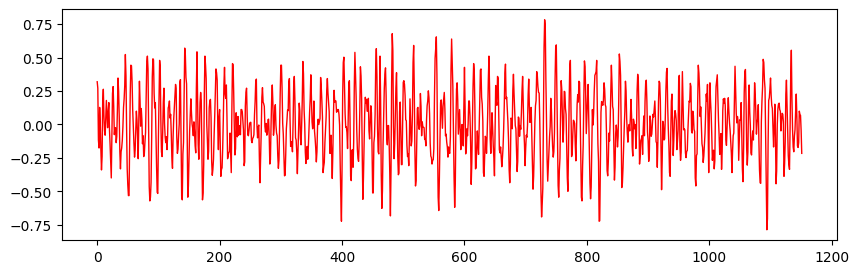

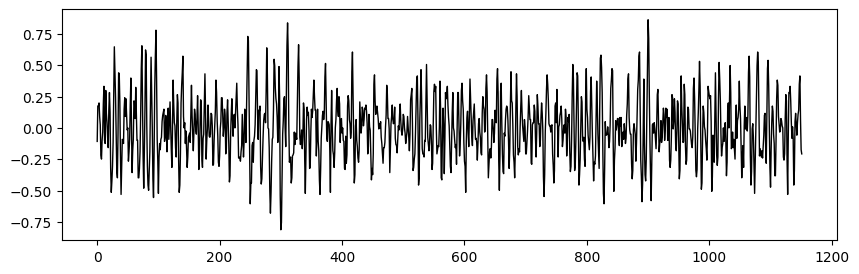

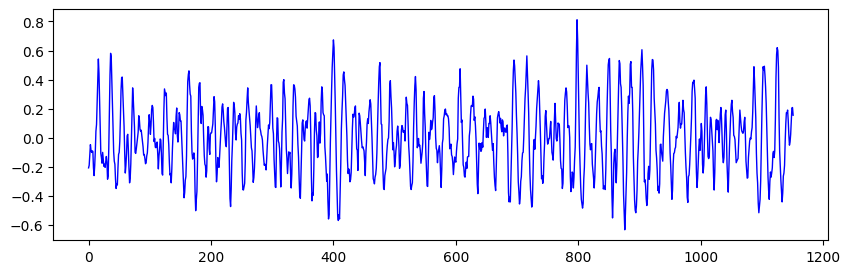

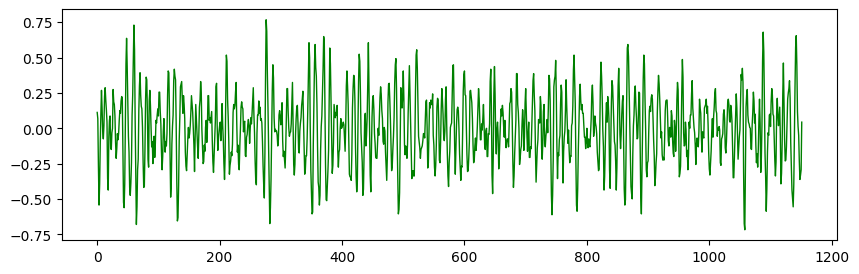

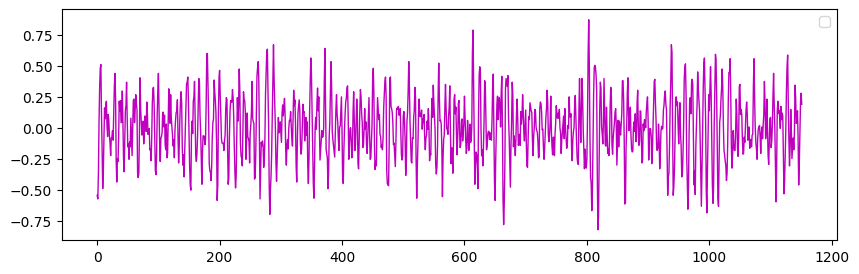

In [18]:
N_data=min([z_disp_rw.shape[0],z_disp_norw.shape[0]])#-1#-110001  #-1
# relative_rw = [0.2, 0.3, 0.4, 0.5, 0.6 ,0.7, 0.8]
relative_rw = [0.5]

for i in range(len(relative_rw)):
    ratio = relative_rw[i]
    if ratio >= 0.5:
        num_rw = z_disp_rw.shape[0]
        num_norw = round(((1-ratio)/ratio) * num_rw)
    else:
        num_norw = z_disp_norw.shape[0]
        num_rw = round((ratio / (1-ratio))*num_norw)

    print(f"The number of rogue wave samples in the case with relative rogue wave ratio {ratio} is {num_rw}.")
    print(f"The number of non-rogue wave samples in the case with relative rogue wave ratio {ratio} is {num_norw}.")
    print(f"The total number of wave samples in the case with relative rogue wave ratio {ratio} is {num_rw + num_norw}.", end='\n') 
        
    z_disp_rw_altered = z_disp_rw[0:num_rw]
    z_disp_norw_altered = z_disp_norw[0:num_norw]
    
    print(z_disp_rw_altered.shape)
    print(z_disp_norw_altered.shape)
    print('\n')

    N_plots=5
    colors = ['r','k','b','g','m']
    selected_samples=random.sample(range(0, len(z_disp_rw)), N_plots)

    k=0
    for iter_plot in selected_samples:
        print(iter_plot)
        plt.figure(figsize=[10,3])
        plt.plot(z_disp_rw[iter_plot,:],color=colors[k], linewidth=1)
        k+=1
        # plt.xticks('off')
        plt.savefig(f"random_wave_window_manyOne{k}.jpg")

    plt.legend(loc='best')    
    
    
    plt.show()
    

    wave_data=np.concatenate((z_disp_rw_altered, z_disp_norw_altered), axis=0)
    labels=np.concatenate(( np.ones(len(z_disp_rw_altered)) , np.zeros(len(z_disp_norw_altered))),axis=0)

    #wave_data_buoy_067=np.concatenate((z_disp_rw_buoy_067, z_disp_norw_buoy_067), axis=0)
    #labels_067=np.concatenate(( np.ones(len(z_disp_rw_buoy_067)) , np.zeros(len(z_disp_norw_buoy_067))),axis=0)

    idx = np.random.permutation(len(wave_data))
    wave_data = wave_data[idx]
    labels=labels[idx]

    #### CREATING THE TRAINING DATA
    
    # wave_data_train=wave_data[0:round(1.0*len(wave_data))]
    # wave_data_test=wave_data[round(1.0*len(wave_data))+1:]                                      

    # label_train=labels[0:round(1.0*len(wave_data))]
    # label_test=labels[round(1.0*len(wave_data))+1:]

    #### CREATING THE TEST DATA
    
    wave_data_train=wave_data[0:round(0.5*len(wave_data))]
    wave_data_test=wave_data[round(0.5*len(wave_data))+1:]                                      

    label_train=labels[0:round(0.5*len(wave_data))]
    label_test=labels[round(0.5*len(wave_data))+1:]


    wave_data_train = wave_data_train.reshape((wave_data_train.shape[0], wave_data_train.shape[1], 1))
    wave_data_test = wave_data_test.reshape((wave_data_test.shape[0], wave_data_test.shape[1], 1))

    num_classes=2

    np.savez(os.getcwd()  +f'/DataPrepared/RWs_H_g_2_tadv_10min_triangular_area_test_rw_{ratio}',wave_data_train=wave_data_train, wave_data_test=wave_data_test,label_train=label_train,label_test=label_test)

- **The different buoys used here for the experiments are displayed [here](https://samarpanchakraborty97.github.io/all_water_buoys_with_distance_triangular_area.html). Training of the neural networks is done using $d_{1}$ and $d_{2}$ while testing data is acquired using buoy $s_{1}$.**